In [97]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

dt.strptime('09/12/2022', '%d/%m/%Y').month


12

In [58]:
raw_data = pd.read_csv(
    "2021/INMET_SE_RJ_A627_NITEROI_01-01-2021_A_31-12-2021.CSV",
    delimiter=";",
    header=8,
    encoding="iso-8859-1",
)

In [59]:
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.loc[:, ~raw_data.columns.str.contains("^Unnamed")].drop(
    columns=[
        "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
        "PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)",
        "PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)",
        "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
        "TEMPERATURA DO PONTO DE ORVALHO (°C)",
        "TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)",
        "TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)",
        "UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)",
        "UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)",
    ]
).rename(
    columns={
        "Data": "date",
        "Hora UTC": "utc-time",
        "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "total-precipitation",
        "RADIACAO GLOBAL (Kj/m²)": "global-radiation",
        "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)": "temperature-last-hour-max",
        "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)": "temperature-last-hour-min",
        "UMIDADE RELATIVA DO AR, HORARIA (%)": "relative-humidity",
        "VENTO, DIREÇÃO HORARIA (gr) (° (gr))": "wind-direction",
        "VENTO, RAJADA MAXIMA (m/s)": "wind-speed-max-gust",
        "VENTO, VELOCIDADE HORARIA (m/s)": "wind-speed",
    }
)
renamed_data

,date,utc-time,total-precipitation,global-radiation,temperature-last-hour-max,temperature-last-hour-min,relative-humidity,wind-direction,wind-speed-max-gust,wind-speed
0,2021/01/01,0000 UTC,0,NaN,"27,4","26,9",81.0,153.0,"2,9","1,4"
1,2021/01/01,0100 UTC,0,NaN,"27,1","26,5",80.0,168.0,3,"1,2"
2,2021/01/01,0200 UTC,0,NaN,"26,5","25,9",80.0,118.0,"3,1","1,4"
3,2021/01/01,0300 UTC,0,NaN,26,"25,5",85.0,3.0,"2,7",1
4,2021/01/01,0400 UTC,0,NaN,"25,8","25,4",83.0,347.0,"2,7",",9"
...,...,...,...,...,...,...,...,...,...,...
8755,2021/12/31,1900 UTC,",4","348,1","25,2",25,92.0,73.0,"5,3","2,2"
8756,2021/12/31,2000 UTC,",2","254,8",25,"24,7",89.0,70.0,"6,4","2,1"
8757,2021/12/31,2100 UTC,",4","95,1","25,1","24,8",89.0,74.0,"6,4","2,2"
8758,2021/12/31,2200 UTC,0,"11,5","25,1","24,8",91.0,62.0,"5,9","1,4"


In [170]:
# parse data to floats

def parseToFloat(col):
    renamed_data[col] = renamed_data[col].apply(lambda x : float(x.replace(',', '.')) if(isinstance(x, str)) else x)

# global-radiation
parseToFloat('global-radiation')

# precipitation
parseToFloat('total-precipitation')

# temperature
parseToFloat('temperature-last-hour-max')
parseToFloat('temperature-last-hour-min')

# wind
parseToFloat('wind-speed')

renamed_data['wind-speed']

0       1.4
1       1.2
2       1.4
3       1.0
4       0.9
       ... 
8755    2.2
8756    2.1
8757    2.2
8758    1.4
8759    1.4
Name: wind-speed, Length: 8760, dtype: float64

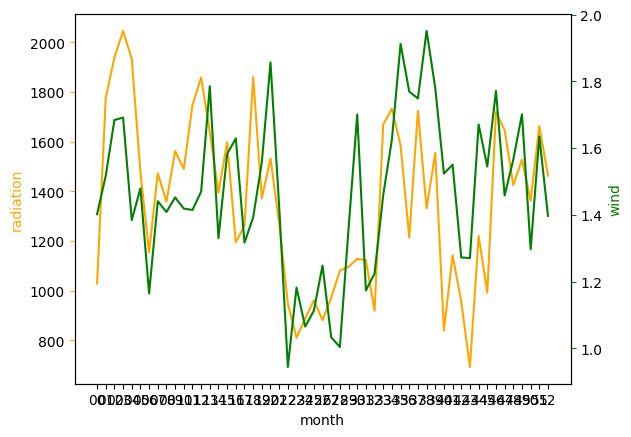

In [251]:
by_month = renamed_data
by_month['month'] =  by_month['date'].apply(lambda d: dt.strftime(dt.strptime(d, '%Y/%m/%d'), '%U'))
monthly_radiation = by_month.groupby('month')['global-radiation'].transform('mean')
monthly_precipitation = by_month.groupby('month')['total-precipitation'].transform('mean')
monthly_wind = by_month.groupby('month')['wind-speed'].transform('mean')
months = by_month['month']

fig, ax1 = plt.subplots()



ax1.set_xlabel('month')
# ax1.set_xticks([months[i] for i in range(0, len(months),3)])
ax1.tick_params()
ax1.set_ylabel('radiation', color='orange')
ax1.plot(months, monthly_radiation, color='orange')
ax1.tick_params(axis='y', color='orange')

# ax2= ax1.twinx()
# ax2.set_ylabel('precipitation')
# ax2.plot(months, monthly_precipitation)
# ax2.tick_params(axis='y')

ax3 = ax1.twinx()
ax3.set_ylabel('wind', color='green')
ax3.plot(months, monthly_wind, color='green')
ax3.tick_params(axis='y', color='green')

plt.show()


In [230]:
rad_study = renamed_data.drop(columns=['wind-direction']).groupby('utc-time').head()

rad_study

,date,utc-time,total-precipitation,global-radiation,temperature-last-hour-max,temperature-last-hour-min,relative-humidity,wind-speed-max-gust,wind-speed,month
0,2021/01/01,0000 UTC,0.0,NaN,27.4,26.9,81.0,"2,9",1.4,00
1,2021/01/01,0100 UTC,0.0,NaN,27.1,26.5,80.0,3,1.2,00
2,2021/01/01,0200 UTC,0.0,NaN,26.5,25.9,80.0,"3,1",1.4,00
3,2021/01/01,0300 UTC,0.0,NaN,26.0,25.5,85.0,"2,7",1.0,00
4,2021/01/01,0400 UTC,0.0,NaN,25.8,25.4,83.0,"2,7",0.9,00
...,...,...,...,...,...,...,...,...,...,...
115,2021/01/05,1900 UTC,0.0,1736.9,32.7,30.6,64.0,"6,1",2.9,01
116,2021/01/05,2000 UTC,0.0,1018.7,31.6,30.4,62.0,5,2.2,01
117,2021/01/05,2100 UTC,0.0,732.6,31.4,30.8,65.0,"3,9",2.0,01
118,2021/01/05,2200 UTC,0.0,89.9,30.9,29.4,72.0,"3,9",0.5,01
